In [7]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def parse_wf_from_binary(filename):
    data_list = []
    nlines=0
    nevents=2000
    with open(filename, "rb") as f:
        while True:
            # Read the header                                                                                                                                                                                                                    
            data = f.read(4)  # Read uint32_t EVID                                                                                                                                                                                               
            if not data:
                break
            EVID = struct.unpack("<I", data)[0]
            data = f.read(8)  # Read uint64_t T                                                                                                                                                                                                  
            if not data:
                break
            T = struct.unpack("<Q", data)[0]
            data = f.read(4)  # Read uint32_t size                                                                                                                                                                                               
            if not data:
                break
            size = struct.unpack("<I", data)[0]
            data = f.read(8)  # Read uint64_t sampl_time                                                                                                                                                                                         
            if not data:
                break
            sampl_time = struct.unpack("<Q", data)[0]
            data = f.read(4)  # Read uint32_t ch (number of channels)                                                                                                                                                                            
            if not data:
                break
            ch = struct.unpack("<I", data)[0]
            waveform_data = {}
            # Read waveforms for each channel                                                                                                                                                                                                    
            for channel in range(ch):
                data = f.read(2)  # Read uint16_t numch                                                                                                                                                                                          
                if not data:
                    break
                numch = struct.unpack("<H", data)[0]
                channel_waveforms = []
                for _ in range(size):
                    data = f.read(4)  # Read float w                                                                                                                                                                                             
                    if not data:
                        break
                    w = struct.unpack("<f", data)[0]
                    channel_waveforms.append(w)
                waveform_data[f'{numch}'] = channel_waveforms
            # Create a row per sample point with all channels aligned                                                                                                                                                                            
            for i in range(size):
                row = {}

                row.update({f'CH{j+1}': waveform_data[f'{numch}'][i]/1e3 for j,numch in enumerate(waveform_data)})
                row.update({"event": EVID})
                row.update({"event_time": T})

                data_list.append(row)

    print(nlines,nevents)
    df = pd.DataFrame(data_list)
    df.insert(0, 'TIME', (df.index % size + 1) * sampl_time/1e9)  # Time in microseconds                                                                                                                                                         
    return df


In [9]:
df = parse_wf_from_binary("Acq_dig2-192.168.0.254_20250616112452-16.bin")

0 2000


In [10]:
df

,TIME,CH1,CH2,CH3,CH4,event,event_time
0,8.000000e-09,-0.043751,-0.076545,-0.014180,-0.042282,14744104,9654707587
1,1.600000e-08,-0.041303,-0.068652,-0.011430,-0.042405,14744104,9654707587
2,2.400000e-08,-0.041548,-0.065103,-0.012163,-0.042036,14744104,9654707587
3,3.200000e-08,-0.043506,-0.064002,-0.015647,-0.039823,14744104,9654707587
4,4.000000e-08,-0.045158,-0.061493,-0.019804,-0.037918,14744104,9654707587
...,...,...,...,...,...,...,...
19999995,7.996800e-05,-0.049992,-0.064369,-0.069251,-0.066987,3762376,9990129537
19999996,7.997600e-05,-0.051889,-0.063145,-0.066134,-0.069199,3762376,9990129537
19999997,7.998400e-05,-0.054643,-0.062594,-0.064300,-0.071473,3762376,9990129537
19999998,7.999200e-05,-0.057396,-0.060698,-0.061978,-0.073440,3762376,9990129537


In [11]:
event_list = df['event'].unique()

In [12]:
an_event = df[df['event']== event_list[2]]

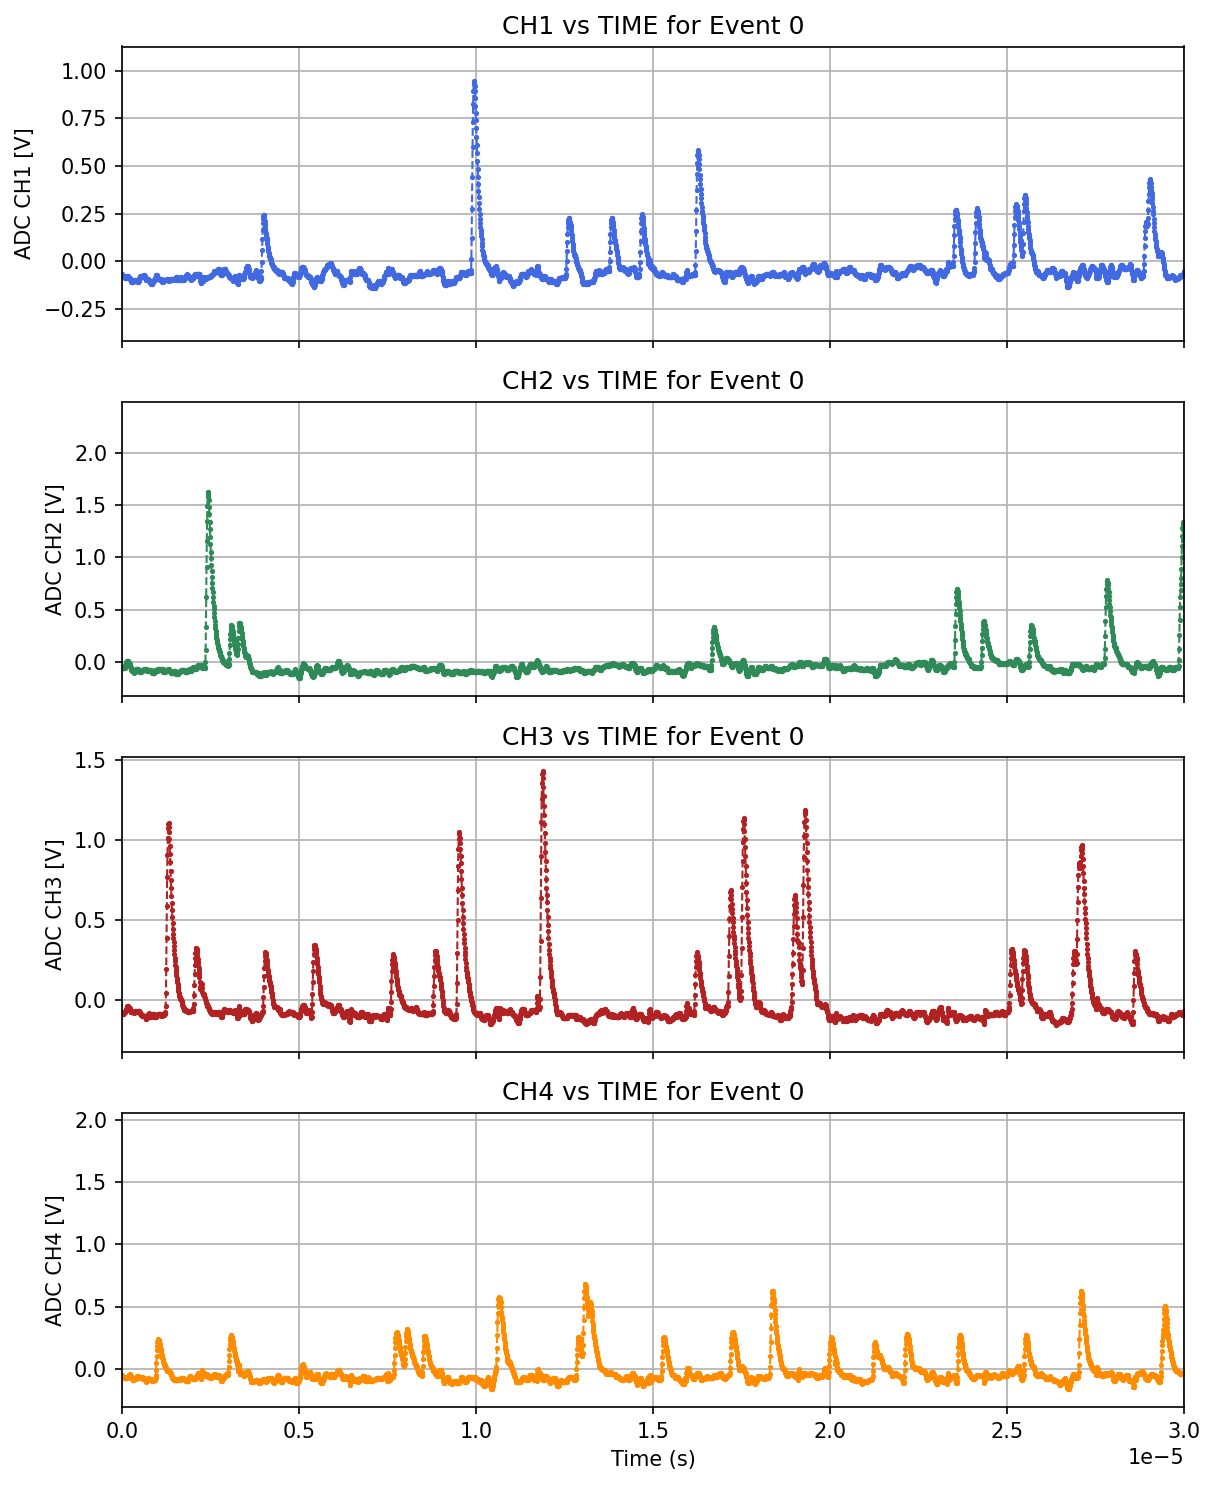

In [16]:
fig, axs = plt.subplots(4, 1, figsize=(8, 10), dpi=150, sharex=True)

channels = ['CH1', 'CH2', 'CH3', 'CH4']
colors = ['royalblue', 'seagreen', 'firebrick', 'darkorange']

for i, ch in enumerate(channels):
    axs[i].plot(an_event['TIME'], an_event[ch], marker='.', linestyle='--',
                color=colors[i], markersize=3, linewidth=1, label=ch)
    axs[i].set_ylabel(f'ADC {ch} [V]')
    axs[i].set_title(f'{ch} vs TIME for Event 0')
    axs[i].grid(True)
    axs[i].set_xlim(0e-6, 30e-6)

axs[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

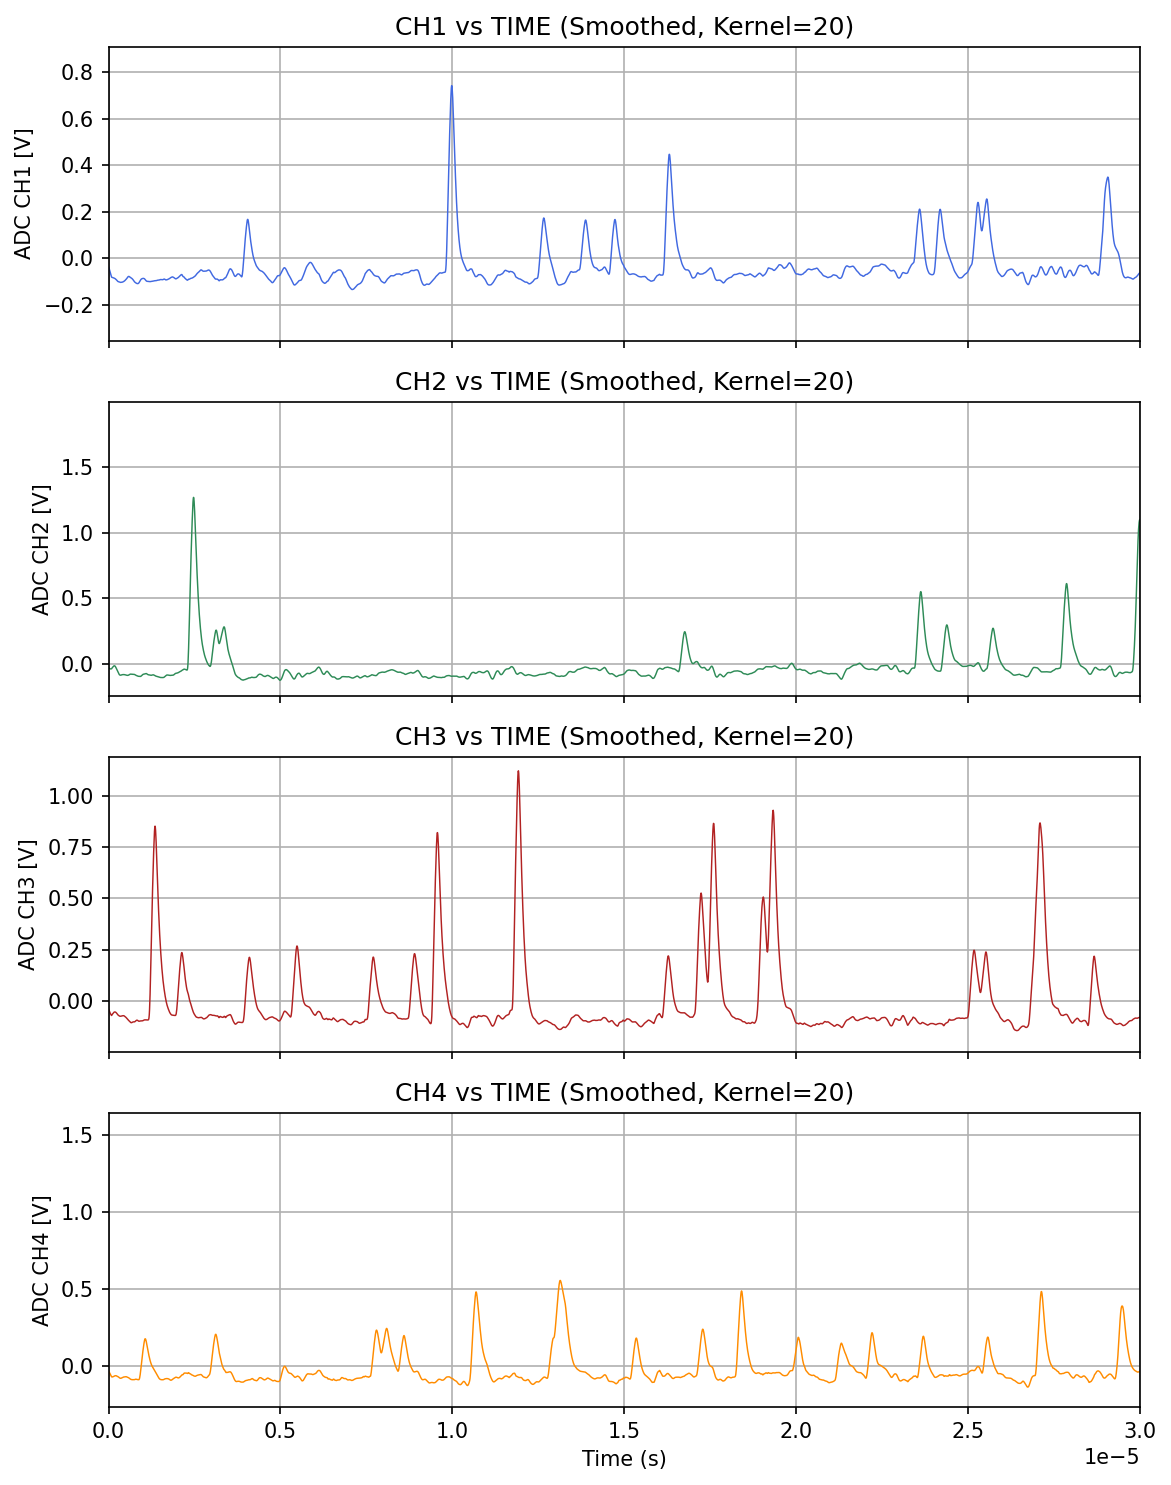

In [31]:
fig, axs = plt.subplots(4, 1, figsize=(8, 10), dpi=150, sharex=True)

channels = ['CH1', 'CH2', 'CH3', 'CH4']
colors = ['royalblue', 'seagreen', 'firebrick', 'darkorange']
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size  # Moving average kernel

for i, ch in enumerate(channels):
    raw_signal = an_event[ch].values
    smoothed_signal = np.convolve(raw_signal, kernel, mode='same')  # Filtered signal

    axs[i].plot(an_event['TIME'], smoothed_signal, linestyle='-', color=colors[i], linewidth=.7, label=f'{ch} (avg)')
    axs[i].set_ylabel(f'ADC {ch} [V]')
    axs[i].set_title(f'{ch} vs TIME (Smoothed, Kernel=20)')
    axs[i].grid(True)
    axs[i].set_xlim(0e-6, 30e-6)

axs[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

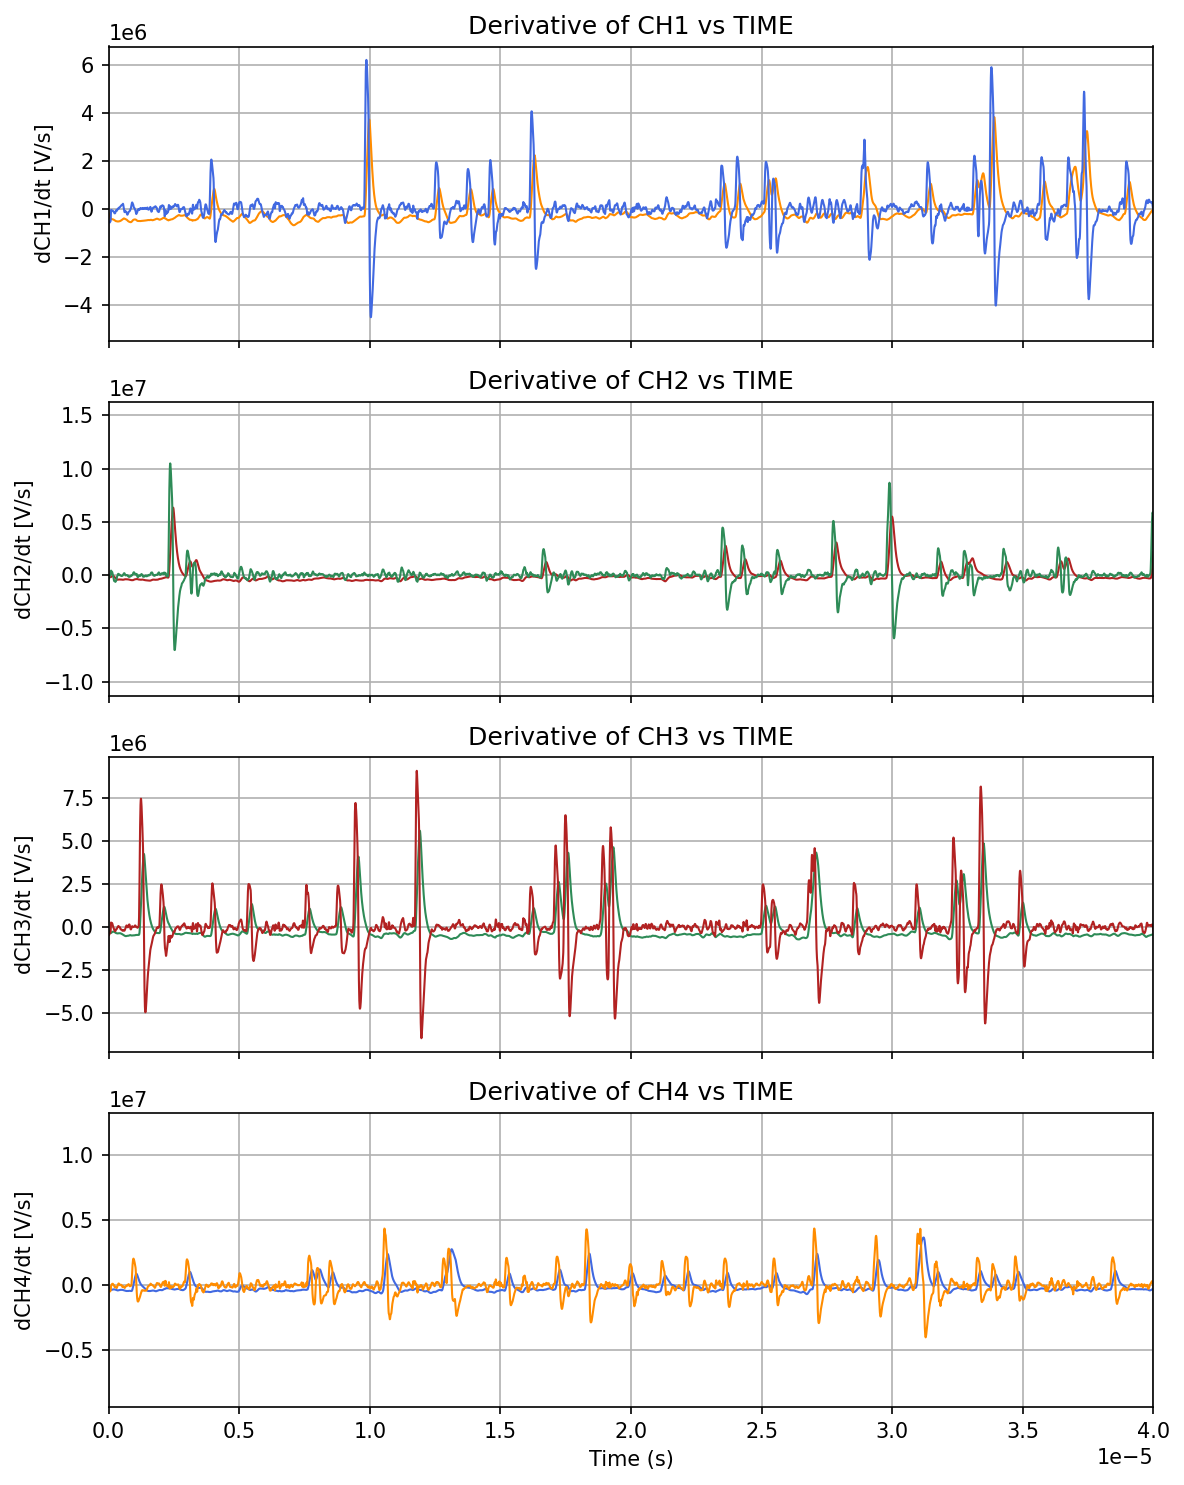

In [38]:
fig, axs = plt.subplots(4, 1, figsize=(8, 10), dpi=150, sharex=True)

channels = ['CH1', 'CH2', 'CH3', 'CH4']
colors = ['royalblue', 'seagreen', 'firebrick', 'darkorange']
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size  # Moving average kernel

time = an_event['TIME'].values

for i, ch in enumerate(channels):
    raw_signal = an_event[ch].values
    smoothed_signal = np.convolve(raw_signal, kernel, mode='same')
    
    # Compute numerical derivative
    d_signal = np.gradient(smoothed_signal, time)

    axs[i].plot(time, smoothed_signal*5e6, linestyle='-', color=colors[len(channels)-1-i], linewidth=1., label=f'{ch} (avg)')
    axs[i].plot(time, d_signal, linestyle='-', color=colors[i], linewidth=1., label=f'd({ch})/dt')
    axs[i].set_ylabel(f'd{ch}/dt [V/s]')
    axs[i].set_title(f'Derivative of {ch} vs TIME')
    axs[i].grid(True)
    axs[i].set_xlim(0e-6, 40e-6)

axs[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()